In [2]:
import numpy as np
import pandas as pd

from functools import partial

from keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from fancyimpute import KNN

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

import xgboost as xgb

def preprocess_data(holdout=0.2, data="breast", data_dim=50):
    
    if data=="breast":
        # import data for breast cancer datasets
        cna_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_CNA_median_sort_common_gene_16884.txt", 
                        header=0, index_col=0, sep="\t")
        rna_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_rna_seq_sort_common_gene_15115.txt", 
                        header=0, index_col=0, sep="\t")
        proteome_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_proteome_filtered.txt", 
                        header=0, index_col=0, sep="\t")
    elif data=="ovarian":
        # import data for ovarian cancer datasets
        cna_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_CNA_sort_common_gene_11859.txt", 
                        header=0, index_col=0, sep="\t")
        rna_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_rna_seq_sort_common_gene_15121.txt", 
                        header=0, index_col=0, sep="\t")
        proteome_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_PNNL_proteome_sort_common_gene_7061.txt", 
                        header=0, index_col=0, sep="\t")
        
    else:
        # both datasets 
        # import data for breast cancer datasets
        cna_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_CNA_median_sort_common_gene_16884.txt", 
                        header=0, index_col=0, sep="\t")
        rna_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_rna_seq_sort_common_gene_15115.txt", 
                        header=0, index_col=0, sep="\t")
        proteome_data_frame = pd.read_csv("../data/sub_challenge_2_3/breast_cancer_dataset/retrospective_breast_proteome_filtered.txt", 
                        header=0, index_col=0, sep="\t")
        
        # import data for ovarian cancer datasets
        cna_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_CNA_sort_common_gene_11859.txt", 
                        header=0, index_col=0, sep="\t")
        rna_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_rna_seq_sort_common_gene_15121.txt", 
                        header=0, index_col=0, sep="\t")
        proteome_data_frame = pd.read_csv("../data/sub_challenge_2_3/ovarian_cancer_dataset/retrospective_ova_PNNL_proteome_sort_common_gene_7061.txt", 
                        header=0, index_col=0, sep="\t")
        
        cna_data_frame = pd.concat([breast_cna_data_frame, ovarian_cna_data_frame], axis=1).dropna()
        rna_data_frame = pd.concat([breast_rna_data_frame, ovarian_rna_data_frame], axis=1).dropna()
        proteome_data_frame = pd.concat([breast_proteome_data_frame, ovarian_proteome_data_frame], axis=1).dropna()

    # convert rna data to numpy array to impute
#     rna_data = rna_data_frame.values

#     # use knn to fill in missing values in rna data
#     knn = KNN(k=5, verbose=0)
#     rna_data = knn.complete(rna_data)

    # proteome data also has missing values, but I am ignoring rows with missing values for now
    # proteome_data = knn.complete(proteome_data)

    # update rna data frame with imputed data
#     rna_data_frame = pd.DataFrame(rna_data, index = rna_data_frame.index, columns = rna_data_frame.columns)

    # find common proteins and patients across all datasets
    proteins = proteome_data_frame.index.intersection(cna_data_frame.index).intersection(rna_data_frame.index)
    patients = proteome_data_frame.columns.intersection(cna_data_frame.columns).intersection(rna_data_frame.columns)

    # locate common data and return as numpy array
    cna_data = cna_data_frame.loc[proteins, patients].values
    rna_data = rna_data_frame.loc[proteins, patients].values
    proteome_data = proteome_data_frame.loc[proteins, patients].values
    
    print "imputing data"
    
    ## KNN to impute missing values
    knn = KNN(k=5, verbose=0)
    
    if np.isnan(cna_data).any():
        cna_data = knn.complete(cna_data)
    if np.isnan(rna_data).any():
        rna_data = knn.complete(rna_data)
    if np.isnan(proteome_data).any():
        proteome_data = knn.complete(proteome_data)
    
    
#     print "PCA to reduced to fixed dimension"
    
#     # PCA to reduce unknown dimension to fixed dimension
#     cna_pca = PCA(n_components=data_dim)
#     rna_pca = PCA(n_components=data_dim)
#     proteome_pca = PCA(n_components=data_dim)
    
#     cna_data = cna_pca.fit_transform(cna_data)
#     rna_data = rna_pca.fit_transform(rna_data)
#     proteome_data = proteome_pca.fit_transform(proteome_data)
    
    print "scaling data"

    # standard scaling
    cna_scaler = StandardScaler()
    rna_scaler = StandardScaler()
    proteome_scaler = StandardScaler()

    cna_data = cna_scaler.fit_transform(cna_data)
    rna_data = rna_scaler.fit_transform(rna_data)
    proteome_data = proteome_scaler.fit_transform(proteome_data)
    
    # mask of training/validation data
    mask = np.random.rand(cna_data.shape[0]) < holdout
    
    cna_training_data = cna_data[~mask]
    rna_training_data = rna_data[~mask]
    proteome_training_data = proteome_data[~mask]
    
    cna_validation_data = cna_data[mask]
    rna_validation_data = rna_data[mask]
    proteome_validation_data = proteome_data[mask]
    
    # return training data scalers for inverse scaling
    return cna_training_data, rna_training_data, proteome_training_data, \
cna_validation_data, rna_validation_data, proteome_validation_data, \
cna_scaler, rna_scaler, proteome_scaler

def rmse (y_pred, y_true): 
    # rsme prediction and ground truth
    return np.sqrt(mse(y_true, y_pred))

# compute mean rmse across a number of repreats
def mean_rmse(cna_training_data, rna_training_data, proteome_training_data, 
            cna_validation_data, rna_validation_data, proteome_validation_data,
              regression_method, num_repeats=1, **kwargs):
    
    abundance_predictions = [regression_method(cna_training_data, rna_training_data, proteome_training_data, 
                                               cna_validation_data, rna_validation_data, **kwargs) 
                             for i in range(num_repeats)]
    
    rmses = np.array([rmse(abundance_prediction, proteome_validation_data) 
                      for abundance_prediction in abundance_predictions])

    return rmses.mean(axis=0)

def linear_regression(cna_training_data, rna_training_data, proteome_training_data, 
                                         cna_validation_data, rna_validation_data, model="linear", **kwargs):
    
    print "Building linear model"
    
    if model == "linear":
        linear_model = LinearRegression()
    elif model == "lasso":
        linear_model = Lasso()
    elif model == "elastic_net":
        linear_model = ElasticNet()
    elif model == "bayesian_ridge":
        linear_model = BayesianRidge()
    
    print "Appending training matrices for linear model"
    
    # append data for linear regression
    cna_rna_training_data_append = np.append(cna_training_data, rna_training_data, axis=1)
    
    print "Fitting linear model"
    
    linear_model.fit(cna_rna_training_data_append, proteome_training_data)
    
    # predictions
    cna_rna_validation_data_append = np.append(cna_validation_data, rna_validation_data, axis=1)
    
    abundance_predictions = linear_model.predict(cna_rna_validation_data_append)
    
    return abundance_predictions

# construct model
def build_deep_regression_model(num_samples, num_hidden, dropout, activation, reg, concatenate):
    
    regulariser = l2(reg)

    cna = Input(shape=(num_samples,))
    rna = Input(shape=(num_samples,))
    
    if concatenate:
        y = Concatenate()([cna, rna])
    else:
        cna_dense = Dense(num_hidden[0], activation=activation, kernel_regularizer=regulariser)(cna)
        rna_dense = Dense(num_hidden[0], activation=activation, kernel_regularizer=regulariser)(rna)
        y = Concatenate()([cna_dense, rna_dense])
   

    for h in num_hidden:
        y = Dense(h, activation=activation, kernel_regularizer=regulariser)(y)
        y = BatchNormalization()(y)
        y = Dropout(dropout)(y)

    y = Dense(num_samples, kernel_regularizer=regulariser)(y)

    deep_non_linear_regression_model = Model([cna, rna], y)
    deep_non_linear_regression_model.compile(optimizer="adam", loss="mse")
    
    return deep_non_linear_regression_model

def deep_non_linear_regression(cna_training_data, rna_training_data, proteome_training_data,
                               cna_validation_data, rna_validation_data,
                               num_hidden=[128], dropout=0.1, activation="relu", reg=1e-3, 
                               concatenate=True, early_stopping=True, **kwargs):
    
    print "Building deep non linear regression model"
    
    # dimensionality of data
    num_proteins, num_samples = cna_training_data.shape
     
    # build model
    regression_model = build_deep_regression_model(num_samples, num_hidden, dropout, activation, reg, concatenate)


    
    print "Training deep non linear regression model"
    
    callbacks=[]
    if early_stopping:
        early_stop = EarlyStopping(monitor="val_loss", patience=1000, min_delta=0, )
        callbacks.append(early_stop)

    # train model
    regression_model.fit([cna_training_data, rna_training_data], proteome_training_data, 
                         verbose=0, epochs=10000, batch_size=128, shuffle=True, validation_split=0.1,#)
                         callbacks=callbacks)

    # protein abundance predictions
    abundance_predictions = regression_model.predict([cna_validation_data, rna_validation_data])
    
    return abundance_predictions

def xgboost(cna_training_data, rna_training_data, proteome_training_data, 
            cna_validation_data, rna_validation_data,**kwargs):
    
    print "Reshaping training matrices for xgboost"
    
    # reshape to columns because xgboost regression can only have single numbers as labels
    cna_training_data_shaped = cna_training_data.reshape(-1, 1)
    rna_training_data_shaped = rna_training_data.reshape(-1, 1)
    proteome_training_data_shaped = proteome_training_data.reshape(-1, 1)
    
    # append cna and rna data
    cna_rna_training_data_append = np.append(cna_training_data_shaped, rna_training_data_shaped, axis=1)
    
    # construct training data matrix
    dtrain = xgb.DMatrix(cna_rna_training_data_append, label=proteome_training_data_shaped)
    
    print "Training xgboost"
    
    # train using default parameters
    bst = xgb.train(dtrain=dtrain, **kwargs)
    
    # abundance predicitions 
    cna_validation_data_shaped = cna_validation_data.reshape(-1, 1)
    rna_validation_data_shaped = rna_validation_data.reshape(-1, 1)
    cna_rna_validation_data_append = np.append(cna_validation_data_shaped, rna_validation_data_shaped, axis=1)
    dval = xgb.DMatrix(cna_rna_validation_data_append)
    abundance_predictions = bst.predict(dval)
    
    return abundance_predictions.reshape(cna_validation_data.shape)

def adaboost(cna_training_data, rna_training_data, proteome_training_data, 
             cna_validation_data, rna_validation_data, base_regressor, **kwargs):
    
    if base_regressor == "linear":
        regressor = LinearRegression()
    elif base_regressor == "lasso":
        regressor = Lasso()
    elif base_regressor == "elastic_net":
        regressor = ElasticNet()
    elif base_regressor == "bayesian_ridge":
        regressor = BayesianRidge()
        
    # reshape to columns because xgboost regression can only have single numbers as labels
    cna_training_data_shaped = cna_training_data.reshape(-1, 1)
    rna_training_data_shaped = rna_training_data.reshape(-1, 1)
    proteome_training_data_shaped = proteome_training_data.reshape(-1, )

    # append cna and rna data
    cna_rna_training_data_append = np.append(cna_training_data_shaped, rna_training_data_shaped, axis=1)    
    
    # adabosst object
    adaboost = AdaBoostRegressor(base_estimator=regressor)
    
    print "fitting adaboost with {}".format(base_regressor)
    
    adaboost.fit(cna_rna_training_data_append, proteome_training_data_shaped)
    
    print "predicting"
    
    cna_validation_data_shaped = cna_validation_data.reshape(-1, 1)
    rna_validation_data_shaped = rna_validation_data.reshape(-1, 1)
    cna_rna_validation_data_append = np.append(cna_validation_data_shaped, rna_validation_data_shaped, axis=1)
    
    abundance_predictions = adaboost.predict(cna_rna_validation_data_append)
    
    return abundance_predictions.reshape(cna_validation_data.shape)

def main(dataset):
    
    print "Preprocessing data"

    # get breast training data
    cna_training_data, rna_training_data, proteome_training_data, \
    cna_validation_data, rna_validation_data, proteome_validation_data, \
    _, _, _ = preprocess_data(data=dataset)
    
    print "loaded dataset"
    
    # linear models
    linear_1 = partial(linear_regression)
    linear_2 = partial(linear_regression, model="lasso")
    linear_3 = partial(linear_regression, model="elastic_net")
#     linear_4 = partial(linear_regression, model="bayesian_ridge")
    
    # different deep architechitures
    deep_1 = partial(deep_non_linear_regression, activation="relu", num_hidden=[], )
    deep_2 = partial(deep_non_linear_regression, activation="relu", num_hidden=[128],)
    deep_3 = partial(deep_non_linear_regression, activation="relu", num_hidden=[128, 64, ] )

    # different xgboost parameters
    xgboost_4 = partial(xgboost, params={"max_depth" : 4})
    xgboost_6 = partial(xgboost, params={"max_depth" : 6})
    xgboost_10 = partial(xgboost, params={"max_depth" : 10})
    xgboost_0 = partial(xgboost, params={"max_depth" : 0})
    
    # adaboost with different base estimators
    adaboost_linear = partial(adaboost, base_regressor="linear")
    adaboost_lasso = partial(adaboost, base_regressor="lasso")
    adaboost_elastic_net = partial(adaboost, base_regressor="elastic_net")
    adaboost_bayesian_ridge = partial(adaboost, base_regressor="bayesian_ridge")
    
    #list of regression methods
    regression_methods = [
        linear_1, 
        linear_2, linear_3, 
#         linear_4, 
        deep_1, 
        deep_2, 
        deep_3, 
                          xgboost_4, xgboost_6, xgboost_10, xgboost_0,
                         adaboost_linear, adaboost_lasso, adaboost_elastic_net, adaboost_bayesian_ridge
    ]
    regression_method_names = [
        "linear_regression", 
        "lasso", "elastic_net", 
#         "bayesian_ridge", 
        "relu_linear_early_stopping", 
        "relu_128_early_stopping", 
        "relu_128_64_early_stopping", 
                               "xgboost_4", "xgboost_6", "xgboost_10", "xgboost_no_limit",
                              "adaboost_linear", "adaboost_lasso", "adaboost_elastic_net", "adaboost_bayesian_ridge"
    ]
    
    # compute rmses
    
    print "Computing rmses"
    rmses = np.array([mean_rmse(cna_training_data, rna_training_data, proteome_training_data,
                                cna_validation_data, rna_validation_data, proteome_validation_data,
                                 regression_method, num_repeats=1) for regression_method in regression_methods])
        
    # convert to data frame
    rmses = pd.DataFrame(rmses, index=regression_method_names)
    
    print "RMSES:"
    print rmses
    
    fname = "../results/subchallenge_2_new/{}_{}.csv".format(dataset, "_".join(regression_method_names))
    print "Saving rmses to {}".format(fname)
    
    # save to file
    rmses.to_csv(fname, sep=",")

if __name__ == "__main__":
    main(dataset="ovarian")

Using TensorFlow backend.
Using cuDNN version 6021 on context None


Preprocessing data
imputing data
scaling data
loaded dataset
Computing rmses
Building linear model
Appending training matrices for linear model
Fitting linear model
Building linear model
Appending training matrices for linear model
Fitting linear model
Building linear model
Appending training matrices for linear model
Fitting linear model
Building deep non linear regression model
Training deep non linear regression model
Building deep non linear regression model
Training deep non linear regression model
Building deep non linear regression model
Training deep non linear regression model
Reshaping training matrices for xgboost
Training xgboost
Reshaping training matrices for xgboost
Training xgboost
Reshaping training matrices for xgboost
Training xgboost
Reshaping training matrices for xgboost
Training xgboost
fitting adaboost with linear
predicting
fitting adaboost with lasso
predicting
fitting adaboost with elastic_net
predicting
fitting adaboost with bayesian_ridge
predicting
RMSES:


Mapped name None to device cuda: GeForce GTX 980M (0000:01:00.0)


In [37]:
cna_training_data, rna_training_data, proteome_training_data, \
cna_validation_data, rna_validation_data, proteome_validation_data, \
_, _, proteome_scaler = preprocess_data(data="ovarian")

Index([u'A1BG', u'A2M', u'AAAS', u'AACS', u'AAK1', u'AAMDC', u'AAMP', u'AAR2',
       u'AARS', u'AARS2',
       ...
       u'ZNRF2', u'ZPR1', u'ZRANB2', u'ZSCAN18', u'ZSWIM8', u'ZW10', u'ZWILCH',
       u'ZYG11B', u'ZYX', u'ZZEF1'],
      dtype='object', name=u'Gene_ID', length=7061)
4795
imputing data
scaling data


In [4]:
import pickle

In [5]:
with open('pca_scaler.pkl', 'wb') as f:
    pickle.dump((proteome_pca, proteome_scaler), f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# dimensionality of data
num_proteins, num_samples = cna_training_data.shape

# build model
regression_model = build_deep_regression_model(num_samples, num_hidden=[], dropout=0.2, 
                                               activation="relu", reg=1e-3, concatenate=True)

regression_model.fit([np.append(cna_training_data, cna_validation_data, axis=0), 
                      np.append(rna_training_data, rna_validation_data, axis=0)], 
                     np.append(proteome_training_data,proteome_validation_data, axis=0), 
                     verbose=0, epochs=10000, batch_size=128, shuffle=True, validation_split=0.,)

In [7]:
import h5py

In [8]:
# serialize model to JSON
model_json = regression_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regression_model.save_weights("model_weights.h5")

In [4]:
cna_linear_model = LinearRegression()

cna_linear_model.fit(cna_training_data, proteome_training_data)

predictions_from_cna = cna_linear_model.predict(cna_validation_data)

In [5]:
rmse(predictions_from_cna, proteome_validation_data)

0.77821940308319604

In [6]:
rna_linear_model = LinearRegression()

rna_linear_model.fit(rna_training_data, proteome_training_data)

predictions_from_rna = rna_linear_model.predict(rna_validation_data)

In [7]:
rmse(predictions_from_rna, proteome_validation_data)

0.81431266922299739

In [ ]:
# train chosen arhcitecture and save weights

model_json = model.to_json()

model.save_weights("model_weights.h5")

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# from fancyimpute import KNN

print "Loading data"

# training data
dfs = [pd.read_csv("../data/sub_challenge_1/data_obs_{}.txt".format(i), 
            header=0, index_col=0, sep="\t") for i in range(1, 11)]

# ground truth
ground_truth_table = pd.read_csv("../data/sub_challenge_1/data_true.txt", 
            header=0, index_col=0, sep="\t")

# conver from data frame ot numpy array
datas = [df.values for df in dfs]
ground_truth = ground_truth_table.values

Loading data


In [4]:
data = datas[0]

In [5]:
from scipy.stats import pearsonr

In [12]:
cors = np.array([[pearsonr(x, y) for y in ground_truth[:1000]] for x in ground_truth[:1000]])

In [13]:
cors[0]

array([[ 1.        ,  0.        ],
       [-0.03336266,  0.76891833],
       [-0.14277888,  0.2064316 ],
       ..., 
       [ 0.014061  ,  0.90147988],
       [-0.1719149 ,  0.12730144],
       [ 0.01881369,  0.86843947]])

In [14]:
import matplotlib.pyplot as plt

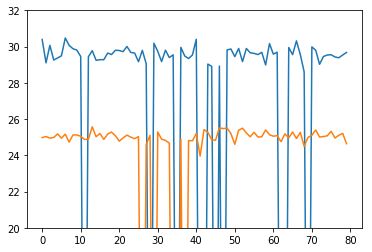

In [23]:

plt.plot(range(ground_truth.shape[1]), ground_truth[0])
# plt.scatter(range(ground_truth.shape[1]), ground_truth[1])
plt.plot(range(ground_truth.shape[1]), ground_truth[200])
plt.ylim(20, 32)
plt.show()

In [17]:
?plt.ylim